<a href="https://colab.research.google.com/github/Wisley1/Genes_ITMO_FALL23/blob/analysis/Neuro_plus_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# @title Transposed data prep
import requests
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

!pip install keras
!pip install shap
import shap
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from tensorflow import keras

#цепляем файлики
url_1 = '/content/drive/MyDrive/Colab Notebooks/ITMO FALL 23`/genes_features_normalized.pkl'
url_2 = '/content/drive/MyDrive/Colab Notebooks/ITMO FALL 23`/genes_targets_normalized.pkl'

#открываем
with open(url_1, 'rb') as file: #features
    data = pickle.load(file)

with open(url_2, 'rb') as file: #targets
    targets = pickle.load(file)

#достаем нужный таргет
targets = targets.loc[targets['ENTITY_STABLE_ID'] == 'AGRN']

#объединяем
df = pd.concat([targets, data])


#вы готовы
df = df.transpose()
df.head()

,70,266,267,268,269,270,271,272,273,274,...,55781,55782,55783,55784,55785,55786,55787,55788,55789,55790
ENTITY_STABLE_ID,AGRN,RP11-431K24.2,RNU1-7P,RP11-431K24.3,RP11-431K24.4,RN7SL729P,RNU6-991P,SLC45A1,Y_RNA,RERE,...,MT-ND3,MT-TR,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT
SKES1_BONE,3.539882,0.0,0.0,0.0,0.0,0.0,0.0,0.69802,0.0,3.470423,...,8.057696,0.254732,0.086583,0.0,0.424418,7.955328,7.77447,0.313495,7.875009,0.0
NCIH1395_LUNG,3.728295,0.0,0.0,0.014842,0.0,0.0,0.0,0.168451,0.0,1.931191,...,7.875009,0.248075,0.0,0.0,0.228576,7.77447,8.057696,0.821715,8.456017,0.0
8MGBA_CENTRAL_NERVOUS_SYSTEM,3.928495,0.018358,0.0,0.0,0.0,0.0,0.0,0.374135,0.0,2.582173,...,7.617393,0.267049,0.0,0.147359,0.183919,7.240781,6.870244,0.126934,7.690037,0.064632
GB1_CENTRAL_NERVOUS_SYSTEM,3.564631,0.0,0.0,0.0,0.0,0.0,0.0,0.80615,0.0,2.413654,...,7.311097,0.0,0.0,0.0,0.0,6.850733,6.595865,0.193022,7.690037,0.0


In [15]:
# @title Delete missing values
df = df.fillna(0)
# Отбор столбцов, где процент нулевых значений больше 50%
null_percentages = df.eq(0).mean()


columns_to_drop = null_percentages[null_percentages > 0.5].index


# Удаление выбранных столбцов
df = df.drop(columns=columns_to_drop)
df = df.drop(index=['ENTITY_STABLE_ID'])

df.head()

,70,272,274,275,279,284,285,286,288,294,...,55776,55778,55780,55781,55783,55785,55786,55787,55788,55789
SKES1_BONE,3.539882,0.69802,3.470423,0.068742,0.049693,7.174483,0.259416,0.365414,0.038536,0.033019,...,2.499865,9.493607,0.501021,8.057696,0.086583,0.424418,7.955328,7.77447,0.313495,7.875009
NCIH1395_LUNG,3.728295,0.168451,1.931191,0.0,0.04572,6.716419,0.447687,0.4399,0.009316,0.136022,...,4.570667,9.493607,0.0,7.875009,0.0,0.228576,7.77447,8.057696,0.821715,8.456017
8MGBA_CENTRAL_NERVOUS_SYSTEM,3.928495,0.374135,2.582173,0.025863,0.0,6.595865,0.118574,0.171211,0.0,0.000153,...,3.175103,9.493607,0.062651,7.617393,0.0,0.183919,7.240781,6.870244,0.126934,7.690037
GB1_CENTRAL_NERVOUS_SYSTEM,3.564631,0.80615,2.413654,0.02518,0.0,8.456017,0.508394,0.433344,0.024122,0.027826,...,2.882694,9.493607,0.0,7.311097,0.0,0.0,6.850733,6.595865,0.193022,7.690037
U87MG_CENTRAL_NERVOUS_SYSTEM,3.138672,1.309224,1.860857,0.068531,0.0,7.690037,0.549374,0.143224,0.0,0.035245,...,2.745861,9.493607,0.0,7.174483,0.0,0.0,6.748965,6.99242,0.25051,7.441481


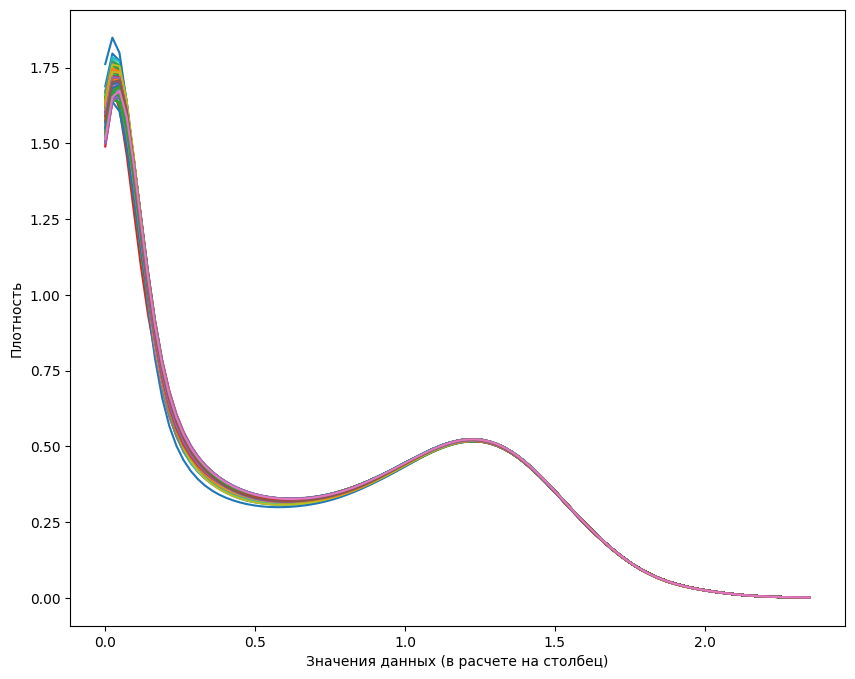

In [3]:
# @title Plot col density
def plot_col_density(data):
    # Применить гауссово сглаживание с целью получения оценки плотности
    density_per_col = [stats.gaussian_kde(col) for col in data]
    x = np.linspace(np.min(data), np.max(data), 100)

    # Установите желаемые значения ширины и высоты
    fig, ax = plt.subplots(figsize=(10, 8))

    for density in density_per_col:
        ax.plot(x, density(x))

    ax.set_xlabel('Значения данных (в расчете на столбец)')
    ax.set_ylabel('Плотность')

    plt.show()

counts = df.iloc[1:,:].values.astype(float)

# До нормализации
log_counts = np.log(counts + 1)
plot_col_density(log_counts)

In [4]:
# @title Most Varibale Rows
def most_variable_rows(data, *, n=1500):
# Вычислить дисперсию вдоль оси столбцов
  rowvar = np.var(data, axis=1)
# Получить отсортированные индексы (в порядке возрастания), взять последние n
  sort_indices = np.argsort(rowvar)[-n:]
# Использовать в качестве индекса для данных
  variable_data = data[sort_indices, :]
  return variable_data

In [5]:
# @title Bicluster
from scipy.cluster.hierarchy import linkage
def bicluster(data, linkage_method='average', distance_metric='correlation'):

  y_rows = linkage(data, method=linkage_method, metric=distance_metric)
  y_cols = linkage(data.T, method=linkage_method, metric=distance_metric)
  return y_rows, y_cols

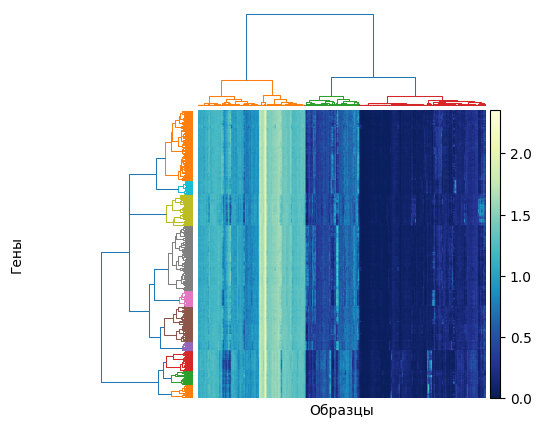

In [6]:
# @title Plot Bicluster
from scipy.cluster.hierarchy import dendrogram, leaves_list
def clear_spines(axes):
  for loc in ['left', 'right', 'top', 'bottom']:
    axes.spines[loc].set_visible(False)
  axes.set_xticks([])
  axes.set_yticks([])


def plot_bicluster(data, row_linkage, col_linkage, row_nclusters=10, col_nclusters=3):

  fig = plt.figure(figsize=(4.8, 4.8))

  ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])

  threshold_r = (row_linkage[-row_nclusters, 2] + row_linkage[-row_nclusters + 1, 2]) / 2
  with plt.rc_context({'lines.linewidth': 0.75}):
    dendrogram(row_linkage, orientation='left', color_threshold = threshold_r, ax = ax1)
  clear_spines(ax1)

  ax2 = fig.add_axes([0.3, 0.71, 0.6, 0.2])
  threshold_c = (col_linkage[-col_nclusters, 2] +
  col_linkage[-col_nclusters+1, 2]) / 2
  with plt.rc_context({'lines.linewidth': 0.75}):
    dendrogram(col_linkage, color_threshold=threshold_c, ax=ax2)
  clear_spines(ax2)

  ax = fig.add_axes([0.3, 0.1, 0.6, 0.6])

  idx_rows = leaves_list(row_linkage)
  data = data[idx_rows, :]
  idx_cols = leaves_list(col_linkage)
  data = data[:, idx_cols]
  im = ax.imshow(data, aspect='auto', origin='lower', cmap='YlGnBu_r')
  clear_spines(ax)

  ax.set_xlabel('Образцы')
  ax.set_ylabel('Гены', labelpad=125)

  axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.6])
  plt.colorbar(im, cax=axcolor)

  plt.show()



counts = df.iloc[1:,:].values.astype(float)
counts_log = np.log(counts + 1)
counts_var = most_variable_rows(counts_log, n=1500)
yr, yc = bicluster(counts_var, linkage_method='ward',
distance_metric='euclidean')
plot_bicluster(counts_var, yr, yc)

In [7]:
# @title Classes of Genes
dictionary = {}

for item in df.index:
    last_word = item.split('_')[-1]
    if last_word not in dictionary:
        dictionary[last_word] = []
    dictionary[last_word].append(item)

print(dictionary.keys())

dict_keys(['BONE', 'LUNG', 'SYSTEM', 'GANGLIA', 'OESOPHAGUS', 'BREAST', 'TISSUE', 'SKIN', 'INTESTINE', 'OVARY', 'GLAND', 'STOMACH', 'PLEURA', 'PROSTATE', 'KIDNEY', 'PANCREAS', 'ENDOMETRIUM', 'TRACT', 'PLACENTA', 'CERVIX', 'THYROID', 'LIVER', 'CORTEX', 'FIBROBLAST'])


In [8]:
# @title Neuro
from sklearn.model_selection import train_test_split
# Разделение на признаки (X) и целевую переменную (y)
X = df.iloc[:,1:] # Удаление колонки '70' из признаков
y = df.iloc[:,0]  # Целевая переменная - колонка '70'

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Преобразование данных в массивы NumPy
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)
print('X_train', X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)


import tensorflow as tf
# Если ошибка не уменьшается на протяжении указанного количества эпох, то процесс обучения прерывается и модель инициализируется весами с самым низким показателем параметра "monitor"
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # указывается параметр, по которому осуществляется ранняя остановка. Обычно это функция потреть на валидационном наборе (val_loss)
    patience=3, # количество эпох по истечении которых закончится обучение, если показатели не улучшатся
    mode='min', # указывает, в какую сторону должна быть улучшена ошибка
    restore_best_weights=True # если параметр установлен в true, то по окончании обучения модель будет инициализирована весами с самым низким показателем параметра "monitor"
)

# Сохраняет модель для дальнейшей загрузки
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/ITMO FALL 23`', # путь к папке, где будет сохранена модель
    monitor='val_loss',
    save_best_only=True, # если параметр установлен в true, то сохраняется только лучшая модель
    mode='min'
)

# Сохраняет логи выполнения обучения, которые можно будет посмотреть в специальной среде TensorBoard
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='/content/drive/MyDrive/Colab Notebooks/ITMO FALL 23`', # путь к папке где будут сохранены логи
)



# Создание модели нейронной сети
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(27635,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))  # Один выходной нейрон для регрессии

# Компиляция модели
model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])

# Обучение модели
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks = [early_stopping, model_checkpoint, tensorboard])



y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(model.evaluate(X_test, y_test))

print(f"R-квадрат: {r2}")

X_train (619, 27635)
y_train (619,)
X_test (69, 27635)
y_test (69,)
Epoch 1/50
16/16 [==============================] - 8s 107ms/step - loss: 846.3981 - mean_absolute_error: 19.8628 - val_loss: 13.1425 - val_mean_absolute_error: 3.2018
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 30.4474 - mean_absolute_error: 4.6933 - val_loss: 20.4977 - val_mean_absolute_error: 4.3622
Epoch 3/50
16/16 [==============================] - 1s 71ms/step - loss: 7.0861 - mean_absolute_error: 2.2586 - val_loss: 4.2323 - val_mean_absolute_error: 1.8495
Epoch 4/50
16/16 [==============================] - 1s 90ms/step - loss: 2.5349 - mean_absolute_error: 1.2900 - val_loss: 2.0673 - val_mean_absolute_error: 1.2586
Epoch 5/50
16/16 [==============================] - 1s 69ms/step - loss: 1.1098 - mean_absolute_error: 0.8220 - val_loss: 0.8601 - val_mean_absolute_error: 0.6994
Epoch 6/50
16/16 [==============================] - 1s 92ms/step - loss: 0.6551 - mean_absolute_error: 0.6315 -

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


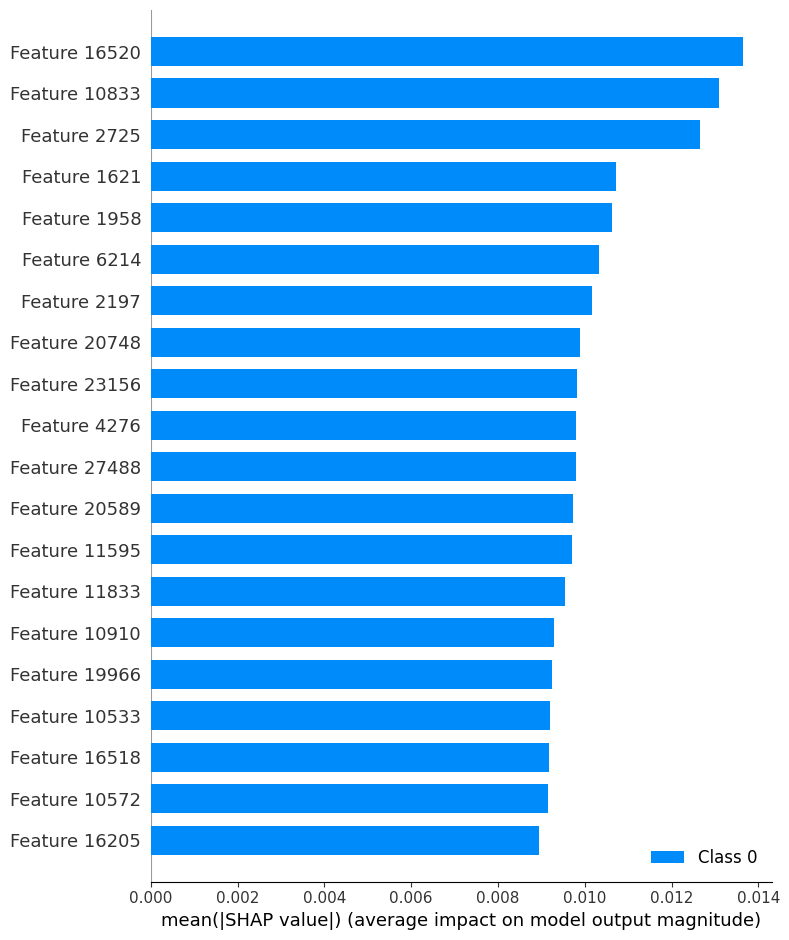

In [9]:
# @title Shap

explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [10]:
list_of_columns = []
for index in dictionary:
  frame = df.loc[dictionary[index]]
  X = frame.iloc[:, 1:]  # Выберите все столбцы, кроме первого, как признаки
  y = frame.iloc[:, 0]   # Выберите первый столбец как целевую переменную

  # Создание модели случайного леса и обучение её на данных
  model = RandomForestRegressor()
  model.fit(X, y)

# Получение важности признаков
  importance = model.feature_importances_

# Создание DataFrame с информацией о важности признаков
  importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importance})

# Сортировка по убыванию важности
  importance_df = importance_df.sort_values("Importance", ascending=False)

# Вывод наиболее ценных столбцов (признаков)
  top_features = importance_df.head(30)
  feature_counts = top_features["Feature"]
  list_of_columns.append(feature_counts)

In [11]:
list_of_columns[1]

12785    26507
19780    40885
14517    29796
5829     11629
11651    24070
5336     10649
736       1490
22935    46452
22915    46424
25517    50898
20947    42953
15052    31186
15264    31460
15119    31276
601       1278
474       1084
24192    48591
21898    44616
13275    27362
15092    31244
7509     15579
12525    25856
9967     20455
12404    25647
23010    46631
11335    23340
23613    47632
26162    52236
8906     18262
23664    47697
Name: Feature, dtype: int64

In [13]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Задаем параметры модели, которые будут перебираться
param_dist = {
    'hidden_layer_sizes': [(randint.rvs(50, 500),) * i for i in range(1, 6)],
    'activation': ['relu', 'tanh'],
}

# Создаем экземпляр модели
model = MLPClassifier()

# Создаем экземпляр RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,  # Количество комбинаций параметров, которые будут проверены
    cv=5,  # Количество фолдов перекрестной проверки
    scoring='accuracy',  # Метрика оценки модели
    random_state=42
)

# Генерация случайных данных для демонстрации
X = X_train
y = y_train

# Запуск процесса подбора оптимальных параметров
random_search.fit(X, y)

# Вывод результатов
print("Лучшие параметры: ", random_search.best_params_)
print("Лучшая оценка: ", random_search.best_score_)

ValueError: ignored